# Calculate the area of the enclosed geometric object with psydat file

In [1]:
from psychopy.misc import fromFile
import numpy as np
import matplotlib.pyplot as plt

### Import
A psydat file can be imported using the psychopy `fromFile` function: 
If you want to know the detailed content of the data in psydat file, please check the notebook 'raw_data.ipynb'

In [2]:
psydata = fromFile("example.psydat")

### Plot of results for each trial
For example, a scatter plot of the mouse positions for each trial, labelled by the condition, trial number and repetition number:

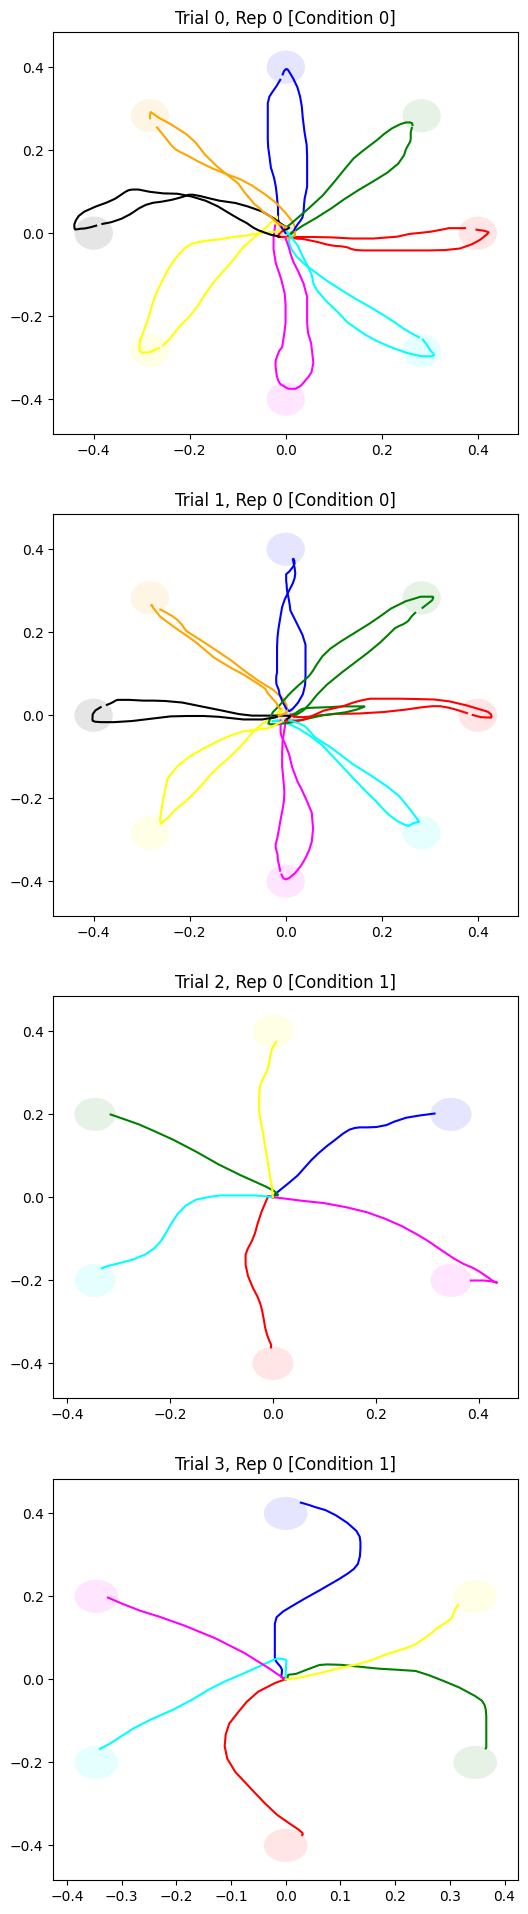

In [3]:
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "orange"]

nTrials, nReps = psydata.sequenceIndices.shape
fig, axs = plt.subplots(nTrials, nReps, figsize=(6, 6 * nTrials * nReps))
axs = np.reshape(
    axs, (nTrials, nReps)
)  # ensure axs is a 2d-array even if nTrials or nReps is 1
for trial in range(nTrials):
    for rep in range(nReps):
        loc = (trial, rep)
        condition = psydata.sequenceIndices[loc]
        target_radius = psydata.trialList[condition]["target_size"]
        central_target_radius = psydata.trialList[condition]["central_target_size"]
        ax = axs[loc]
        ax.set_title(f"Trial {trial}, Rep {rep} [Condition {condition}]")
        for positions, target_pos, color in zip(
            psydata.data["to_target_mouse_positions"][loc],
            psydata.data["target_pos"][loc],
            colors,
        ):
            ax.plot(positions[:, 0], positions[:, 1], color=color)
            ax.add_patch(
                plt.Circle(
                    target_pos,
                    target_radius,
                    edgecolor="none",
                    facecolor=color,
                    alpha=0.1,
                )
            )
        if not psydata.trialList[condition]["automove_cursor_to_center"]:
            for positions, color in zip(
                psydata.data["to_center_mouse_positions"][loc],
                colors,
            ):
                ax.plot(positions[:, 0], positions[:, 1], color=color)
            ax.add_patch(
                plt.Circle(
                    [0, 0],
                    central_target_radius,
                    edgecolor="none",
                    facecolor="black",
                    alpha=0.1,
                )
            )

plt.show()

### Plot of area calculation results for each trial

How to calculate the area of irregular geometric object with given coordinates from psydat file?

The build-in operation `area` in the library `shapely` can calculate the area of geometry object. However, only for the valid one->not self intersected.

To tackle the self-intersection problem, the strategy is to split one self intersected object into the union of `LineString`(a geometry type composed of one or more line segments), then construct a bunch of valid polygons from these lines, then calculate the area of each valid polygon, sum them up.

In [4]:
from shapely.geometry import LineString
from shapely.ops import polygonize, unary_union
from typing import List, Tuple

In [5]:
def get_area_and_polygons(
    to_target_mouse_positions: np.ndarray, to_center_mouse_positions: np.ndarray
) -> Tuple[float, List[np.ndarray]]:
    """
    Calculates the total area enclosed by the mouse positions and the corresponding list of closed polygons

    Uses the built-in operation `area` in the library `shapely` to calculate the area of geometry object.
    However, this is only available for valid (not self intersected) geometries.
    To tackle the self-intersection problem,
    the strategy is to split one self intersected object into the union of LineString (a geometry type composed of one or more line segments),
    then construct a bunch of valid polygons from these lines,
    then calculate the area of each valid polygon and sum them up.

    :param to_target_mouse_positions: x,y mouse positions moving towards the target
    :param to_center_mouse_positions: x,y mouse positions moving towards the center
    :return: area, list of x and y arrays of corresponding closed polygons

    """
    coords = np.concatenate(
        [
            to_target_mouse_positions,
            to_center_mouse_positions,
            to_target_mouse_positions[0:1],
        ]
    )
    polygons = polygonize(unary_union(LineString(coords)))
    area = sum(polygon.area for polygon in polygons)
    xy_arrays = [np.array(xy) for polygon in polygons for xy in polygon.exterior.xy]
    return area, xy_arrays

---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.023840
green, area: 0.016878
red, area: 0.012411
cyan, area: 0.015122
magenta, area: 0.018386
yellow, area: 0.026584
black, area: 0.014029
orange, area: 0.009765
---------------------------------------------
area of Trial 1, Rep 0 [Condition 0]
blue, area: 0.012711
green, area: 0.022543
red, area: 0.008020
cyan, area: 0.008811
magenta, area: 0.014737
yellow, area: 0.014034
black, area: 0.011179
orange, area: 0.004766


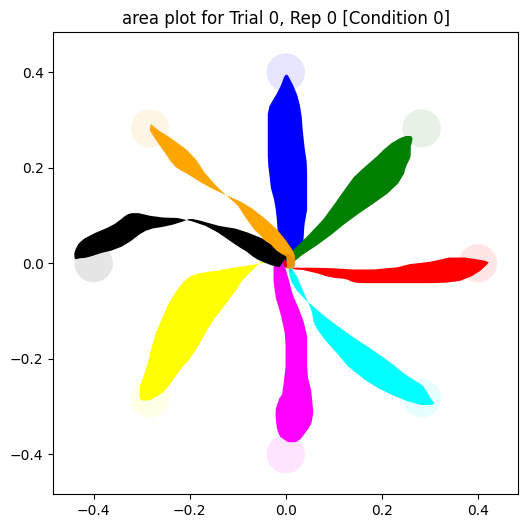

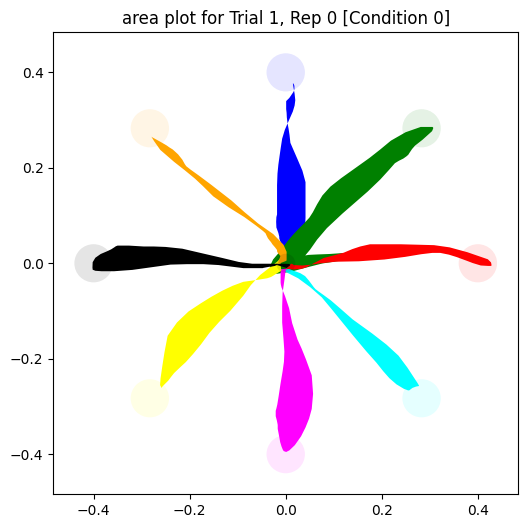

In [6]:
def plot_and_calculate_area(data):
    nTrials, nReps = data.sequenceIndices.shape
    for trial in range(nTrials):
        for rep in range(nReps):
            loc = (trial, rep)
            condition = data.sequenceIndices[loc]
            central_target_radius = data.trialList[condition]["central_target_size"]

            # if condition "automove_cursor_to_center" is deselected, plot the line to center, fill the enclosed area and output the area
            if not data.trialList[condition]["automove_cursor_to_center"]:
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.set_xbound(-0.5, 0.5)
                ax.set_ybound(-0.5, 0.5)
                ax.set_title(
                    f"area plot for Trial {trial}, Rep {rep} [Condition {condition}]"
                )
                print("---------------------------------------------")
                print(
                    "area of Trial %d, Rep %d [Condition %s]" % (trial, rep, condition)
                )
                for (
                    to_target_mouse_positions,
                    to_center_mouse_positions,
                    target_pos,
                    color,
                ) in zip(
                    data.data["to_target_mouse_positions"][loc],
                    data.data["to_center_mouse_positions"][loc],
                    data.data["target_pos"][loc],
                    colors,
                ):
                    area, polygons = get_area_and_polygons(to_target_mouse_positions, to_center_mouse_positions)
                    ax.fill(*polygons, facecolor=color)

                    ax.add_patch(
                        plt.Circle(
                            target_pos,
                            target_radius,
                            edgecolor="none",
                            facecolor=color,
                            alpha=0.1,
                        )
                    )
                    print("%s, area: %f" % (color, area))

                ax.add_patch(
                    plt.Circle(
                        [0, 0],
                        central_target_radius,
                        edgecolor="none",
                        facecolor="black",
                        alpha=0.1,
                    )
                )

    plt.show()


plot_and_calculate_area(psydata)

### Special cases
This strategy can also be applied to the following special cases:

#### no movement
There is no lines in the plot

---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.000000
green, area: 0.000000
red, area: 0.000000
cyan, area: 0.000000
magenta, area: 0.000000
yellow, area: 0.000000
black, area: 0.000000
orange, area: 0.000000


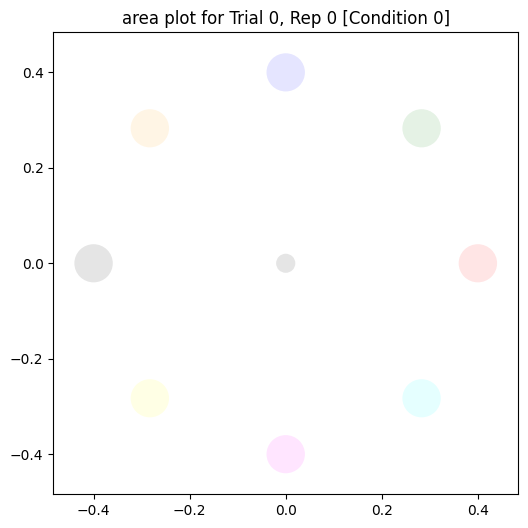

In [7]:
psydata_no_movement = fromFile("example_no_movement.psydat")
plot_and_calculate_area(psydata_no_movement)

#### too much movement
The whole plot is full of lines

---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.920733
green, area: 1.062104
red, area: 0.262005
cyan, area: 1.181816
magenta, area: 1.167541
yellow, area: 1.221113
black, area: 0.818421
orange, area: 0.325764


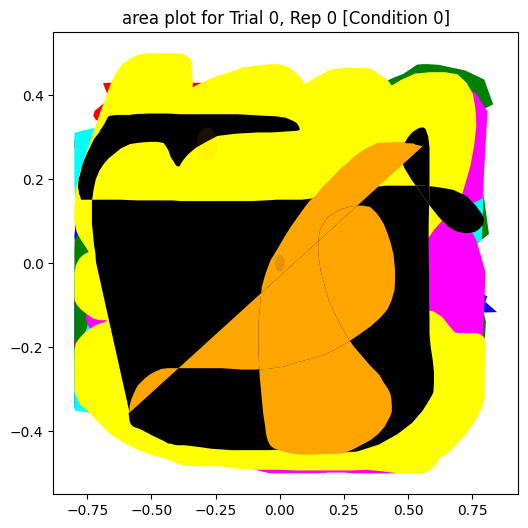

In [8]:
psydata_over_movement = fromFile("example_over_movement.psydat")
plot_and_calculate_area(psydata_over_movement)

#### some targets got reached, some not
For some targets, no line is approaching them, the corresponding area is 0

---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.000000
green, area: 0.136767
red, area: 0.028414
cyan, area: 0.000000
magenta, area: 0.055633
yellow, area: 0.085676
black, area: 0.000000
orange, area: 0.953468


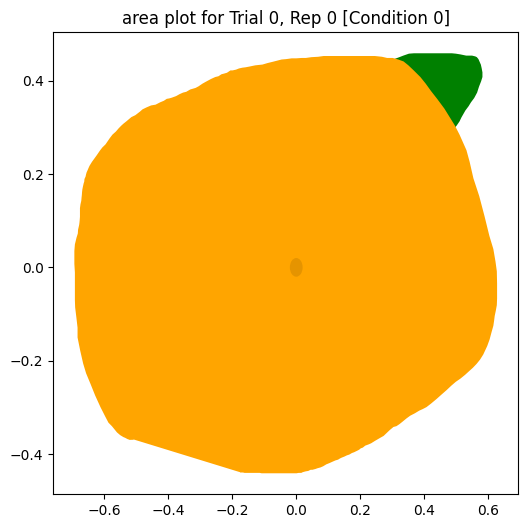

In [9]:
psydata_target_not_reached = fromFile("example_target_not_reached.psydat")
plot_and_calculate_area(psydata_target_not_reached)

#### select "Automatically move cursor to center" condition
The trials with condition "Automatically move cursor to center" selected will not be drawn, only the trials with condition "Automatically move cursor to center" deselected will be shown in the plot.

---------------------------------------------
area of Trial 1, Rep 0 [Condition 1]
blue, area: 0.013264
green, area: 0.000636
red, area: 0.044108
cyan, area: 0.074389
magenta, area: 0.002066
yellow, area: 0.001862


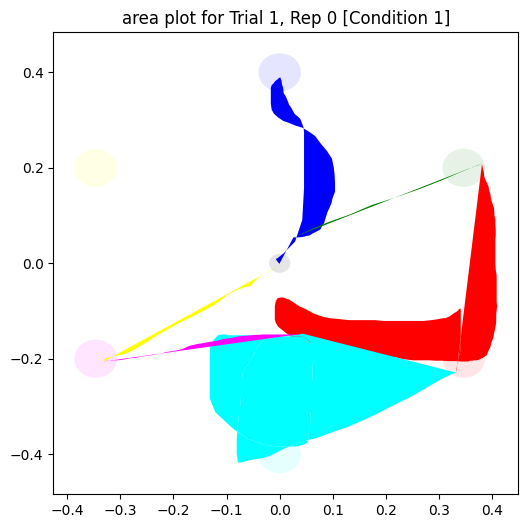

In [10]:
psydata_select_back_to_center = fromFile("example_select_back_to_center.psydat")
plot_and_calculate_area(psydata_select_back_to_center)

#### not closed line
For the path from the center to target and back to center is not closed, will be closed by the first and last coordinates automatically.

---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.132591
green, area: 0.203647


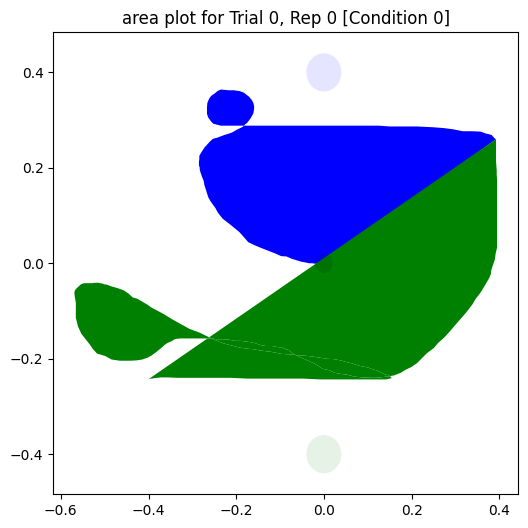

In [11]:
psydata_not_closed_line = fromFile("example_not_closed_line.psydat")
plot_and_calculate_area(psydata_not_closed_line)